In [1]:
import random
import heapq
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

In [2]:
def generate_random_maps(width, height):
    # Initialize an empty map
    map = [[0 for x in range(width)] for y in range(height)]

    # Place obstacles in the center
    obstacle_count = 0
    while obstacle_count < 20:
        x = random.randint(width//3, 2*width//3)
        y = random.randint(height//3, 2*height//3)
        if map[y][x] == 0:
            map[y][x] = 1
            obstacle_count += 1

    
    # Place start and end points on the map
    map[15][0] = 2
    map[15][31] = 3
    
    return map

In [3]:
def a_star(start, goal, grid):
    # Define the heuristic function
    def heuristic(a, b):
        # Use Euclidean distance as the heuristic
        return math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    
    # Define the neighbors function
    def neighbors(point):
        x, y = point
        results = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        results = filter(lambda p: 0 <= p[0] < len(grid) and 0 <= p[1] < len(grid[0]), results)
        results = filter(lambda p: grid[p[0]][p[1]] == 0, results)
        return results
    
    # Initialize the open and closed sets
    open_set = []
    closed_set = set()
    
    # Add the starting point to the open set
    heapq.heappush(open_set, (0, start))
    
    # Initialize the cost and came_from dictionaries
    cost = {start: 0}
    came_from = {}
    
    # Loop until the open set is empty
    while open_set:
        # Pop the lowest-cost point from the open set
        current_cost, current_point = heapq.heappop(open_set)
        
        # If the current point is the goal, reconstruct and return the path
        if current_point == goal:
            path = [current_point]
            while current_point in came_from:
                current_point = came_from[current_point]
                path.append(current_point)
            path.reverse()
            return path
        
        # Add the current point to the closed set
        closed_set.add(current_point)
        
        # Loop through the current point's neighbors
        for neighbor in neighbors(current_point):
            # Calculate the tentative cost to the neighbor
            tentative_cost = cost[current_point] + 1
            
            # If the neighbor is already in the closed set and the new cost is greater than or equal to the old cost, skip it
            if neighbor in closed_set and tentative_cost >= cost.get(neighbor, float('inf')):
                continue
            
            # If the neighbor is not in the open set or the new cost is less than the old cost, add it to the open set
            if tentative_cost < cost.get(neighbor, float('inf')):
                came_from[neighbor] = current_point
                cost[neighbor] = tentative_cost
                priority = tentative_cost + heuristic(goal, neighbor)
                heapq.heappush(open_set, (priority, neighbor))
    
    # If the open set is empty and the goal has not been reached, there is no path
    return None

In [4]:
def distance(p1, p2):
    # Calculate the Euclidean distance between two points
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

In [5]:
def find_start_end(map):
    # Find the start and end points
    start, end = None, None
    for y in range(len(map)):
        for x in range(len(map[0])):
            if map[y][x] == 2:
                start = (x, y)
            elif map[y][x] == 3:
                end = (x, y)
            if start is not None and end is not None:
                return start, end
    # If start and end points are not found, raise an error
    raise ValueError("Start or end point not found in map")

In [6]:
# Define the colors used for the map and path
COLOR_MAP = (255, 255, 255)  # white
COLOR_OBSTACLE = (0, 0, 0)  # black
COLOR_START = (0, 255, 0)  # green
COLOR_GOAL = (0, 0, 255)  # red
COLOR_PATH = (255, 0, 0)  # blue

# Define the size of each cell in the image
CELL_SIZE = 1

def create_map_image(map):
    # Create a blank image with the correct dimensions
    image = np.zeros((len(map) * CELL_SIZE, len(map[0]) * CELL_SIZE, 3), dtype=np.uint8)
    start, goal = find_start_end(map)

    # Loop through each cell in the map and draw it in the image
    for i in range(len(map)):
        for j in range(len(map[0])):
            # Determine the color of the cell
            if map[i][j] == 1:
                color = COLOR_OBSTACLE
            else:
                color = COLOR_MAP
            
            # Draw the cell in the image
            x = j * CELL_SIZE
            y = i * CELL_SIZE
            cv2.rectangle(image, (x, y), (x + CELL_SIZE, y + CELL_SIZE), color, -1)

            #Draw start and goal in the map
            start_x = start[1] * CELL_SIZE + CELL_SIZE // 2
            start_y = start[0] * CELL_SIZE + CELL_SIZE // 2
            goal_x = goal[1] * CELL_SIZE + CELL_SIZE // 2
            goal_y = goal[0] * CELL_SIZE + CELL_SIZE // 2
            cv2.circle(image, (start_x, start_y), CELL_SIZE // 2, COLOR_START, -1)
            cv2.circle(image, (goal_x, goal_y), CELL_SIZE // 2, COLOR_GOAL, -1)
    
    return image

In [7]:
def draw_path_on_image(image, path):
    # Loop through each point in the path and draw it on the image
    for i in range(len(path)-1):
        # Determine the coordinates of the two points
        x1 = path[i][1] * CELL_SIZE + CELL_SIZE // 2
        y1 = path[i][0] * CELL_SIZE + CELL_SIZE // 2
        x2 = path[i+1][1] * CELL_SIZE + CELL_SIZE // 2
        y2 = path[i+1][0] * CELL_SIZE + CELL_SIZE // 2
        
        # Draw a line between the two points
        cv2.line(image, (x1, y1), (x2, y2), COLOR_PATH, 1)
    
    return image

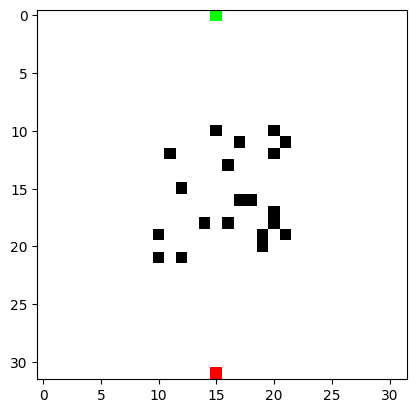

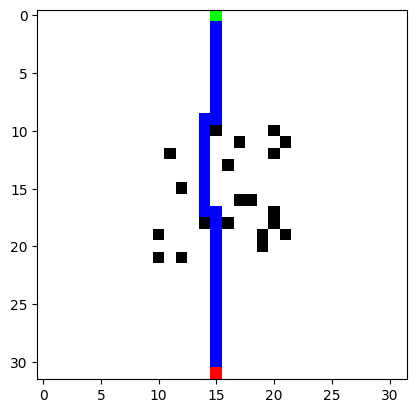

In [8]:
# Generate a random map
map = generate_random_maps(32, 32)

# Generate random start and goal points
start, goal = find_start_end(map)

# Run the A* algorithm to find the path
path = a_star(start, goal, map)
if path == "None":
  print("No path found")

# Create an image of the map
map_image = create_map_image(map)

# Draw the path on the image
path_image = draw_path_on_image(map_image.copy(), path)

# Draw the start and goal points on the image
start_x = start[1] * CELL_SIZE + CELL_SIZE // 2
start_y = start[0] * CELL_SIZE + CELL_SIZE // 2
goal_x = goal[1] * CELL_SIZE + CELL_SIZE // 2
goal_y = goal[0] * CELL_SIZE + CELL_SIZE // 2
cv2.circle(path_image, (start_x, start_y), CELL_SIZE // 2, COLOR_START, -1)
cv2.circle(path_image, (goal_x, goal_y), CELL_SIZE // 2, COLOR_GOAL, -1)

# Display the images
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(path_image, cv2.COLOR_BGR2RGB))  
plt.show()


In [9]:
def preprocess_image(img):

    # Convert the input image to grayscale and resize to 64x64
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LINEAR)

    # Convert the input image to a numpy array
    img = np.array(img)

    # # Normalize the input image to the range [-1, 1]
    # img = (img.astype(np.float32) / 255.0)
    img = (img - 127.5) / 127.5

    # Add a channel dimension to the input image
    img = np.expand_dims(img, axis=-1)

    # # Reshape the input image to match the expected shape of the generator model
    # img = np.reshape(img, (1, 32, 32, 1))
    
    return img

In [10]:
def generate_dataset(n):
    map_images = []
    path_images = []
    i = 0
    while i != n:
        map_data = generate_random_maps(32, 32)
        map_image = create_map_image(map_data)
        start, goal = find_start_end(map_data)
        path = a_star(start, goal, map)
        if path is not None:
            path_image = draw_path_on_image(map_image.copy(), path)
            map_image  = preprocess_image(map_image)
            path_image = preprocess_image(path_image)
            map_images.append(map_image)
            path_images.append(path_image)
            i+=1
    return np.array(map_images), np.array(path_images)

In [11]:
X, Y = generate_dataset(1000)

In [12]:
# Convert the input and target images to TensorFlow tensors and create a TensorFlow dataset
input_images = tf.convert_to_tensor(X)
target_images = tf.convert_to_tensor(Y)
dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))
# # Batch into 128 images per sample
dataset = dataset.batch(128)
# # Reduces the likelihood of bottlenecking 
dataset = dataset.prefetch(64)

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=(32, 32, 1)))
    model.add(layers.LeakyReLU(0.2))

    #upsampling 1
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    # convulation layers
    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    
    # #pooling
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(32, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    # Output layer
    model.add(layers.Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [14]:
test_model = make_generator_model()

In [15]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 1)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 1)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1088      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        65600     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                        

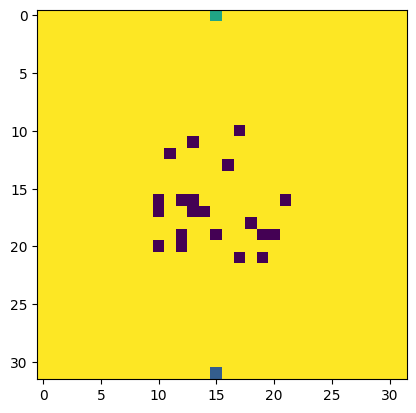

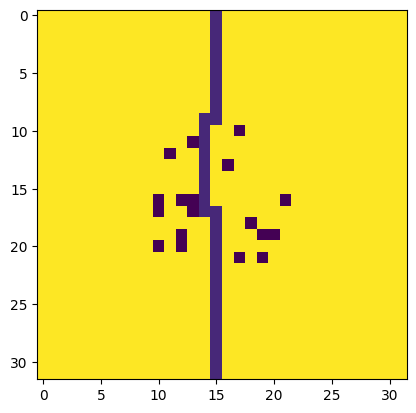

1/1 [==============================] - 2s 2s/step


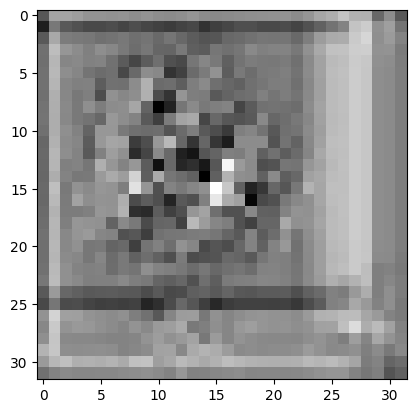

In [16]:
img_1 = input_images[2]
plt.imshow(img_1)
plt.show()
img_1 = np.reshape(img_1, (1, 32, 32, 1))
out_1 = target_images[2]
plt.imshow(out_1)
plt.show()
p1 = test_model.predict(img_1)
p1_squeezed = np.squeeze(p1, axis=0)
plt.imshow(p1_squeezed, cmap="gray")

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=(32, 32, 1)))
    model.add(layers.LeakyReLU(0.2))

    # Convolutional layers
    model.add(layers.Conv2D(32, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, 4, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [18]:
test_disc = make_discriminator_model()

In [19]:
test_disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        544       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)       

In [20]:
print(p1_squeezed.shape)
test_check_true = test_disc.predict(np.expand_dims(p1_squeezed, 0))
print(test_check_true)

(32, 32, 1)
1/1 [==============================] - 0s 250ms/step
[[0.49988413]]


In [21]:
#Define the optimizers for the generator and discriminator
generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.00001)

gen_loss = tf.keras.losses.BinaryCrossentropy()
disc_loss = tf.keras.losses.BinaryCrossentropy()

In [22]:
#Define the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

#Define the loss functions for the generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00001)

In [24]:
# Define the training loop
gen_loss = 0
disc_loss = 0

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate a path image from the input image using the generator
        generated_path = generator(input_image, training=True)

        # Get the outputs of the discriminator for the real and generated path images
        real_output = discriminator(target, training=True)
        fake_output = discriminator(generated_path, training=True)

        # Calculate the loss for the generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the optimizer for the generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(epoch+1, "started")
        for input_image, target in dataset:

            # Train the generator and discriminator on the input and target images
            train_step(input_image, target)

        # Print the loss for the generator and discriminator at the end of each epoch
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}: Generator Loss = {gen_loss}, Discriminator Loss = {disc_loss}")

In [25]:
train(dataset, 20)

1 started
2 started
3 started
4 started
5 started
6 started
7 started
8 started
9 started
10 started
Epoch 10: Generator Loss = 0, Discriminator Loss = 0
11 started
12 started
13 started
14 started
15 started
16 started
17 started
18 started
19 started
20 started
Epoch 20: Generator Loss = 0, Discriminator Loss = 0


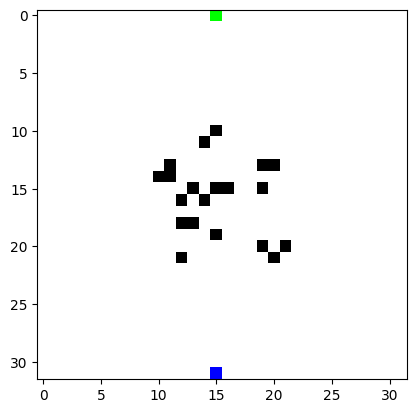

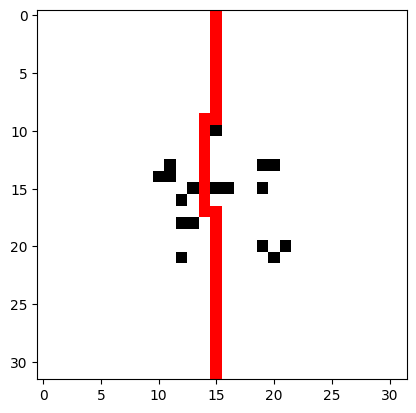

In [26]:
test_map_data = generate_random_maps(32, 32)
test_map_image = create_map_image(test_map_data)
start, goal = find_start_end(test_map_data)
test_path = a_star(start, goal, map)
test_path_image = draw_path_on_image(test_map_image.copy(), test_path)
plt.imshow(test_map_image)
plt.show()
plt.imshow(test_path_image)

In [27]:
test_map_image_pre = preprocess_image(test_map_image)
generated_map = generator.predict(test_map_image_pre)

1/1 [==============================] - 1s 539ms/step


In [28]:
generated_map = generated_map*255

In [29]:
np.unique(generated_map)

array([128.98279, 129.62477, 131.65369, 133.47536, 133.47537, 133.79868,
       133.82285, 134.09068, 134.20181, 134.67456, 134.82132, 134.94482,
       134.95059, 134.95068, 134.9507 , 135.15001, 135.1501 , 135.15012,
       135.38208, 135.38313, 135.4806 , 135.48064, 135.48476, 135.52148,
       135.54462, 135.56485, 135.63765, 135.65607, 135.65608, 135.70085,
       135.85114, 135.95372, 136.11165, 136.12599, 136.17479, 136.17496,
       136.21729, 136.40428, 136.41086, 136.4865 , 136.4882 , 136.48825,
       136.55838, 136.68613, 136.68628, 136.70299, 136.70316, 136.70413,
       136.70505, 136.72922, 136.7449 , 136.74744, 136.74745, 136.7476 ,
       136.79117, 136.79176, 136.80473, 136.80475, 136.81621, 136.82837,
       136.85493, 136.89006, 136.9012 , 136.90341, 136.90952, 136.9512 ,
       136.99373, 137.00026, 137.04085, 137.05159, 137.0517 , 137.05803,
       137.05806, 137.07162, 137.09932, 137.12756, 137.13419, 137.14247,
       137.14252, 137.14795, 137.16444, 137.17857, 

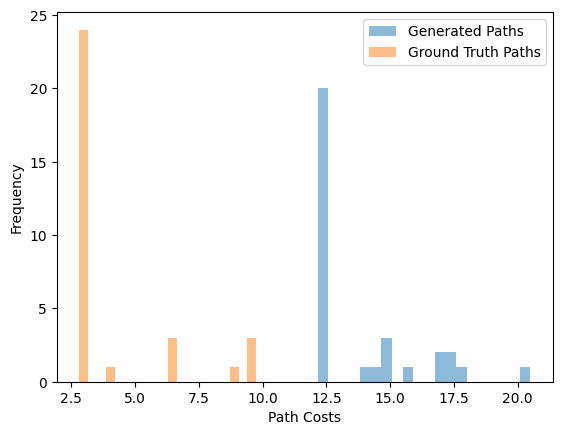

In [30]:
# Compute the cost of each generated path using a cost function appropriate for your use case
def path_cost(path):
    return np.sum(np.sqrt(np.sum(np.diff(path, axis=0) ** 2, axis=1)))

generated_path_costs = [path_cost(path) for path in generated_map]
ground_truth_path_costs = [path_cost(path) for path in test_path_image]

# Compare the distribution of generated path costs to the distribution of path costs in the testing set
plt.hist(generated_path_costs, bins=20, alpha=0.5, label='Generated Paths')
plt.hist(ground_truth_path_costs, bins=20, alpha=0.5, label='Ground Truth Paths')
plt.xlabel("Path Costs")
plt.ylabel("Frequency")
plt.legend()

In [31]:
gt_path = (test_path_image).astype(np.uint8)
test_map_image_copy = test_map_image.copy()

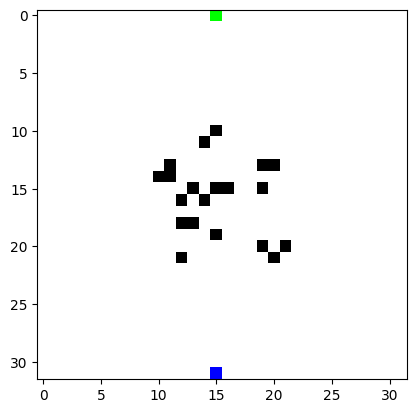

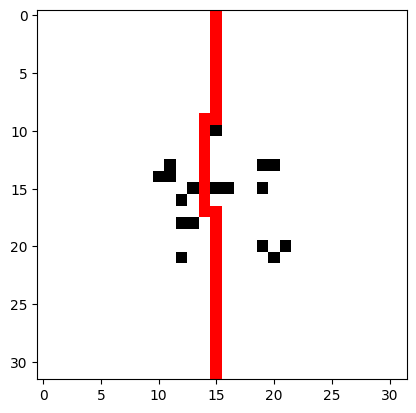

In [32]:
# # Plot the input image
plt.imshow(test_map_image)
plt.show()
plt.imshow(gt_path)
plt.show()

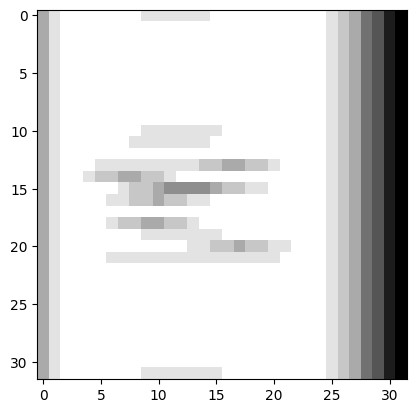

In [33]:
gen_path = np.squeeze(generated_map, axis=3)
gen_path = np.round(gen_path).astype(np.int32)
plt.imshow(gen_path, cmap="gray")
plt.show()
